In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Audio Feature Extraction with Librosa

In [2]:
# pip install -u librosa

# sudo apt-get install build-essential
# sudo apt-get install libxext-dev python-qt4 qt4-dev-tools
# pip install librosa

In [3]:
import librosa
import librosa.display
import librosa.feature

A set of music samples from the website:
http://theremin.music.uiowa.edu
This website has a great set of samples for audio processing.

In [5]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

req = requests.get(url)
with open(fn, "wb") as file:
    file.write(req.content) # write to file

In [6]:
y, sr = librosa.load(fn)

Extracting features from audio files is an entire subject on its own right. A commonly used
set of features are called the Mel Frequency Cepstral Coefficients (MFCCs). These are derived
from the so-called mel spectrogram which is something like a regular spectrogram, but the power
and frequency are represented in log scale, which more naturally aligns with human perceptual
processing. You can run the code below to display the mel spectrogram from the audio sample.
You can easily see the four notes played in the audio track. You also see the ’harmonics’ of
each notes, which are other tones at integer multiples of the fundamental frequency of each note.

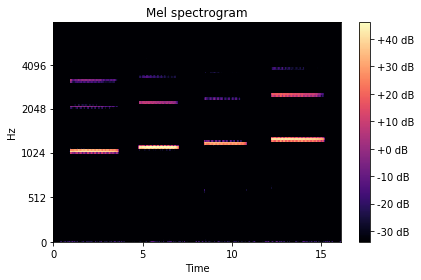

In [7]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.amplitude_to_db(S),
y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

use their processed
data provided at:
https://github.com/marl/dl4mir-tutorial/blob/master/README.md
Note the password. Load the four files into some directory, say instrument_dataset. Then,
load them with the commands.

In [10]:
data_dir = '/Users/apple/Downloads/instrument_dataset/'
Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

In [11]:
print('Num training= {0:d}'.format(Xtr.shape[0]))
print('Num test= {0:d}'.format(Xts.shape[0]))
print('Num features= {0:d}'.format(Xtr.shape[1]))
print('Num classes= {0:d}'.format(np.max(ytr)+1))

Num training= 66247
Num test= 14904
Num features= 120
Num classes= 10


In [12]:
xmean = np.mean(Xtr,axis=0)
xstd = np.std(Xtr,axis=0)
Xtr_scale = (Xtr-xmean[None,:])/xstd[None,:]
Xts_scale = (Xts-xmean[None,:])/xstd[None,:]

## Building a Neural Network Classifier



In [13]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation

In [14]:
import tensorflow.keras.backend as K
K.clear_session()

In [15]:
nin = Xtr.shape[1]
nout = np.max(ytr)+1
nh = 256
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation='softmax', name='output'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 256)               30976     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
_________________________________________________________________


In [17]:
from tensorflow.keras import optimizers


opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

In [18]:
batch_size = 100
hist = model.fit(Xtr_scale, ytr, epochs=10, batch_size=batch_size, validation_data = (Xts_scale, yts))
                
                 
                 

Train on 66247 samples, validate on 14904 samples
Epoch 1/10
66247/66247 [==============================] - 2s 37us/sample - loss: 0.3681 - accuracy: 0.9008 - val_loss: 0.1873 - val_accuracy: 0.9460
Epoch 2/10
66247/66247 [==============================] - 2s 31us/sample - loss: 0.1028 - accuracy: 0.9756 - val_loss: 0.0928 - val_accuracy: 0.9773
Epoch 3/10
66247/66247 [==============================] - 2s 33us/sample - loss: 0.0605 - accuracy: 0.9850 - val_loss: 0.0739 - val_accuracy: 0.9803
Epoch 4/10
66247/66247 [==============================] - 2s 27us/sample - loss: 0.0425 - accuracy: 0.9898 - val_loss: 0.0515 - val_accuracy: 0.9852
Epoch 5/10
66247/66247 [==============================] - 2s 29us/sample - loss: 0.0324 - accuracy: 0.9919 - val_loss: 0.0434 - val_accuracy: 0.9867
Epoch 6/10
66247/66247 [==============================] - 2s 37us/sample - loss: 0.0259 - accuracy: 0.9933 - val_loss: 0.0343 - val_accuracy: 0.9911
Epoch 7/10
66247/66247 [==============================] 

Text(0,0.5,'Test accuracy')

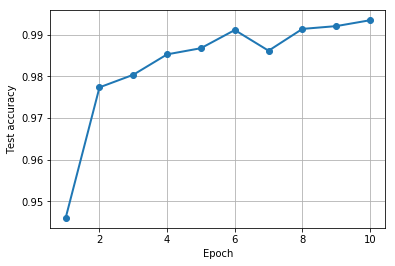

In [20]:
val_acc = hist.history['val_accuracy']
nepochs = len(val_acc)
plt.plot(np.arange(1,nepochs+1), val_acc, 'o-', linewidth=2)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Test accuracy')

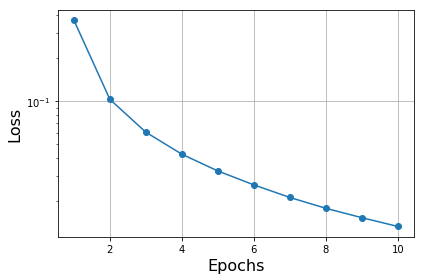

In [21]:
loss = hist.history['loss']
plt.semilogy(np.arange(1,nepochs+1), loss, 'o-')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.grid()
plt.tight_layout()

## Optimizing the Learning Rate

One challenge in training neural networks is the selection of the learning rate. 

In [22]:
rates = [0.01,0.001,0.0001]
batch_size = 100
loss_hist = []

for lr in rates:
    K.clear_session()
    
    model = Sequential()
    model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
    model.add(Dense(nout, activation='softmax', name='output'))
    
    opt = optimizers.Adam(lr=lr)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    hist = model.fit(Xtr_scale, ytr, epochs=20, batch_size=batch_size, validation_data=(Xts_scale,yts))
    
    loss_hist.append( hist.history['loss'])
    
    val_acc = hist.history['val_accuracy'][-1]
    print("lr=%12.4e test accuracy=%f" % (lr, val_acc))

Train on 66247 samples, validate on 14904 samples
Epoch 1/20
66247/66247 [==============================] - 2s 29us/sample - loss: 0.1060 - accuracy: 0.9666 - val_loss: 0.0519 - val_accuracy: 0.9822
Epoch 2/20
66247/66247 [==============================] - 2s 32us/sample - loss: 0.0275 - accuracy: 0.9909 - val_loss: 0.0729 - val_accuracy: 0.9723
Epoch 3/20
66247/66247 [==============================] - 2s 26us/sample - loss: 0.0215 - accuracy: 0.9928 - val_loss: 0.0248 - val_accuracy: 0.9907
Epoch 4/20
66247/66247 [==============================] - 2s 27us/sample - loss: 0.0168 - accuracy: 0.9944 - val_loss: 0.0264 - val_accuracy: 0.9910
Epoch 5/20
66247/66247 [==============================] - 2s 29us/sample - loss: 0.0149 - accuracy: 0.9952 - val_loss: 0.0445 - val_accuracy: 0.9845
Epoch 6/20
66247/66247 [==============================] - 3s 42us/sample - loss: 0.0154 - accuracy: 0.9949 - val_loss: 0.0391 - val_accuracy: 0.9870
Epoch 7/20
66247/66247 [==============================] 

66247/66247 [==============================] - 2s 30us/sample - loss: 0.0740 - accuracy: 0.9831 - val_loss: 0.0913 - val_accuracy: 0.9758
Epoch 15/20
66247/66247 [==============================] - 2s 27us/sample - loss: 0.0678 - accuracy: 0.9847 - val_loss: 0.0853 - val_accuracy: 0.9779
Epoch 16/20
66247/66247 [==============================] - 2s 25us/sample - loss: 0.0624 - accuracy: 0.9855 - val_loss: 0.0791 - val_accuracy: 0.9799
Epoch 17/20
66247/66247 [==============================] - 4s 59us/sample - loss: 0.0578 - accuracy: 0.9863 - val_loss: 0.0774 - val_accuracy: 0.9793
Epoch 18/20
66247/66247 [==============================] - 3s 49us/sample - loss: 0.0538 - accuracy: 0.9873 - val_loss: 0.0728 - val_accuracy: 0.9805
Epoch 19/20
66247/66247 [==============================] - 2s 28us/sample - loss: 0.0503 - accuracy: 0.9879 - val_loss: 0.0661 - val_accuracy: 0.9828
Epoch 20/20
66247/66247 [==============================] - 2s 36us/sample - loss: 0.0473 - accuracy: 0.9886 - va

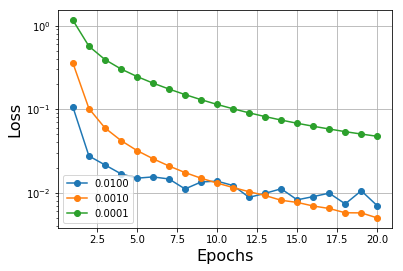

In [24]:
ntest = len(loss_hist)
ntr = Xtr.shape[0]
batch_size=100
for it, loss in enumerate(loss_hist):
    nepochs = len(loss)
    epochs = np.arange(1,nepochs+1)
    plt.semilogy(epochs, loss, 'o-')
    rate_str = ['{0:5.4f}'.format(lr) for lr in rates]
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(rate_str,loc='lower left')
    plt.grid()